# Brain tumor 3D segmentation with Monai
this notebook will recreate the The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS)

comming form Ieee papper

this is the like for there paper:https://ieeexplore.ieee.org/document/6975210

in this notebook will will tackle a lot of things from them we have
1. Transforms for dictionary format data
2. Define a new transformation using Monai
3. Load Nifti image with metadata , load a list of images and stack them
4. augment the data
5. Cache IO and transforms to accelerate training and validation
6. 3D SegResNet model, Dice loss function, Mean Dice metric for 3D segmentation task
7. Deterministic training for reproducibility


the data comes form "http://medicaldecathlon.com/"
(one of the best medical dataset sources that i personally loves so much)

okay so enough yapping let's start:


*   **Target**: Gliomas segmentation necrotic/active tumour and oedema
*   **Modality**: Multimodal multisite MRI data (FLAIR, T1w, T1gd, T2w)
*   **Size**: 750 4D (484 Traning + 266 Testing)
*   **Source**: BRATS 2016 and 2017 datasets.
*   **Challenge**: Complex and heterogeneously-located targets






Below figure shows the wanted reasults from this notebook (this picture taken from https://ieeexplore.ieee.org/document/6975210/)

in this picture we can see the different modalities (top left) and the final labels for the whole dataset(right)  


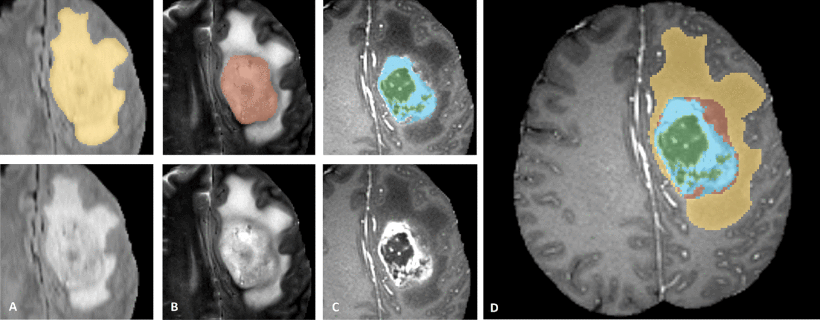

The image patches show from lefft to right :


1.   the whole tumor **yellow** visible in T2-Floair (fig A)
2.  the tumor core **red** visible in T2 (fig B)
3.  the enhancing tumor structures **Cyan** visible in T1Gd, surrounding the cystic/necrotic components of the core **green**
4.  The segmentations are combined to generate the final labels of the tumor sub-region (Fig D) :
*   edema(yellow)
*   non-enhancing solid core (red)
*   necrotic/cystic core (green)
*   enhancing core (blue)







#

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import onnxruntime" || pip install -q onnxruntime
%matplotlib inline


Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.6 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'onnxruntime'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.2 MB/s eta 0:00:00


Setup imports

In [2]:
import os
import shutil 
import tempfile 
import time 
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric 
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism
import onnxruntime
from tqdm import tqdm

import torch 

print_config()

MONAI version: 1.5.dev2451
Numpy version: 1.26.4
Pytorch version: 2.4.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 7c1c58cd10db72c01b5cdda1600cd68e262437cf
MONAI __file__: /usr/local/lib/python3.10/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.13.1
Pillow version: 10.4.0
Tensorboard version: 2.17.0
gdown version: 5.2.0
TorchVision version: 0.19.1+cu121
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.1.4
einops version: 0.8.0
transformers version: 4.44.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.htm

### Setup data directory 

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
if directory is not None:
    os.makedirs(directory, exist_ok=True)
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp1i6j2278


Set derterministic trining for reproducibility

In [4]:
set_determinism(seed=0)


## Define

### Define a new transform to convert brain tumor labels
Here we convert the multiclasses labels into multi-labels segmentation task in On-hot format.

In [5]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

SetupTransforms for taraining 

In [6]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)

Setup transforms for the validation

In [7]:
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

## loading data with DecathlonDataset
Here we use DecathlonDataset to automatically download and extract the dataset. It inherits MONAI CacheDataset

In [8]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=0.0,
    num_workers=4,
)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)


Task01_BrainTumour.tar: 7.09GB [04:43, 26.8MB/s]                            

2024-12-27 17:15:44,054 - INFO - Downloaded: /tmp/tmp1i6j2278/Task01_BrainTumour.tar


2024-12-27 17:15:57,425 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-12-27 17:15:57,426 - INFO - Writing into directory: /tmp/tmp1i6j2278.


In [9]:
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0,
    num_workers=4,
)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)


**Check data shape and visualize**

image shape: torch.Size([4, 224, 224, 144])


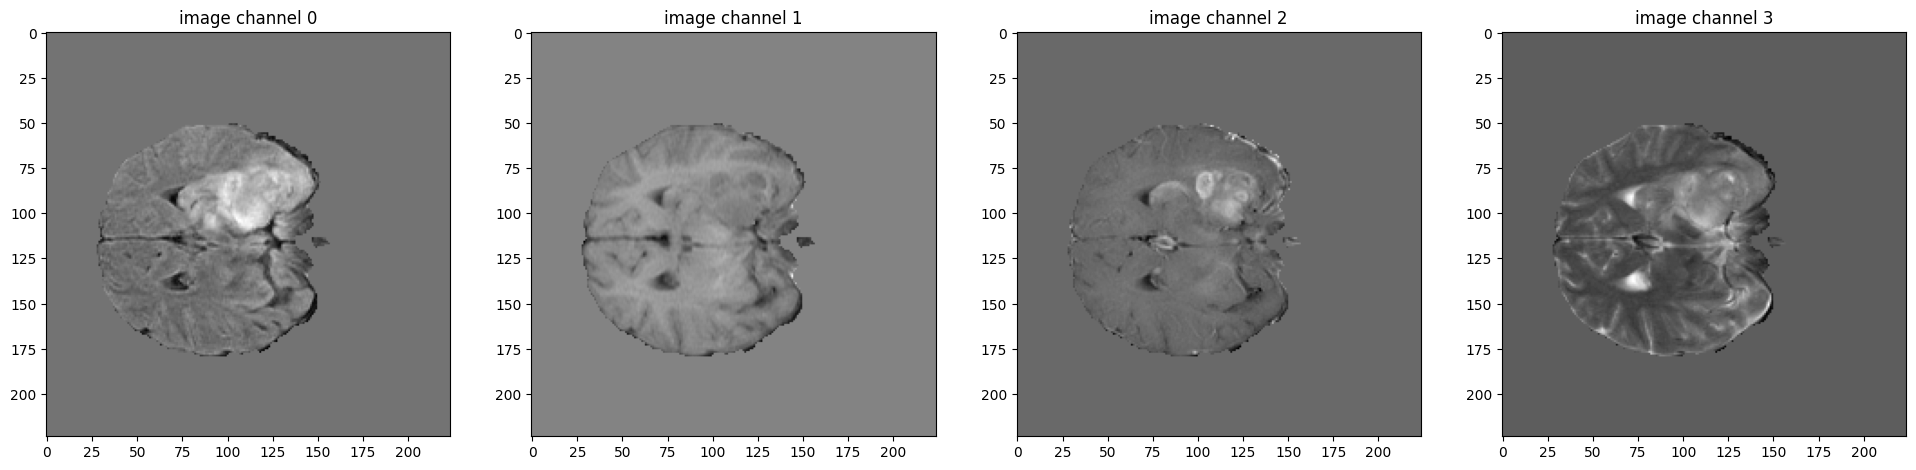

label shape: torch.Size([3, 224, 224, 144])


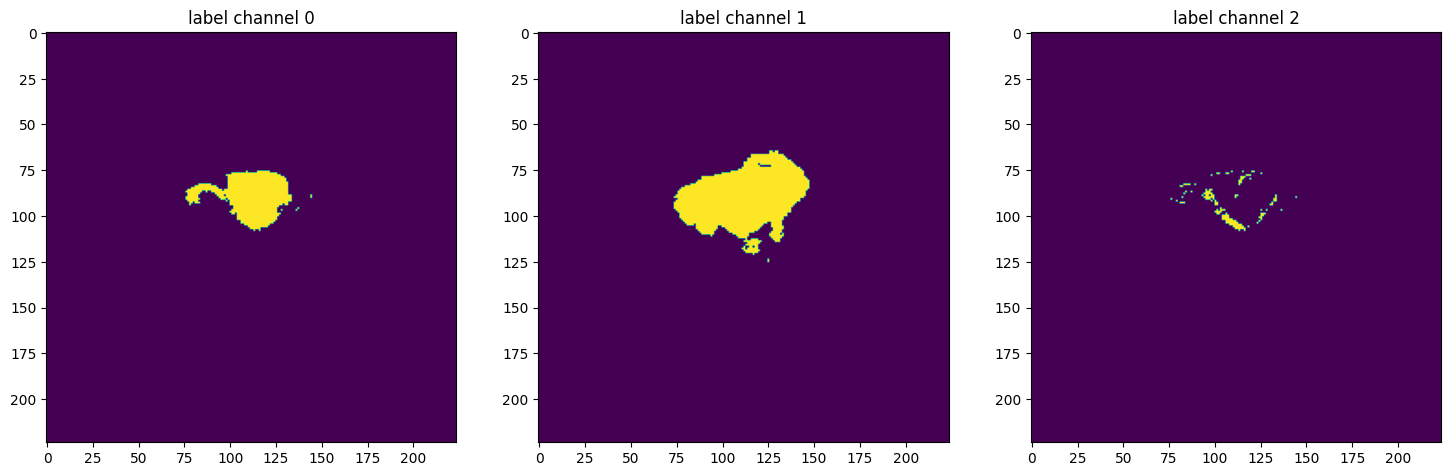

In [10]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = train_ds[5]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

### Create Model, Loss, Optimizer

In [11]:
max_epochs = 15
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.torch.amp.GradScaler('cuda')
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

In [12]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start


----------
epoch 1/15


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-12-55cbd8c64a00>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


1/388, train_loss: 0.9783, step time: 9.8883
2/388, train_loss: 0.9804, step time: 0.9777
3/388, train_loss: 0.9883, step time: 0.9984
4/388, train_loss: 0.9560, step time: 0.9992
5/388, train_loss: 0.9834, step time: 1.0079
6/388, train_loss: 0.9384, step time: 0.9972
7/388, train_loss: 0.9720, step time: 1.0826
8/388, train_loss: 0.9390, step time: 1.0016
9/388, train_loss: 0.9850, step time: 0.9972
10/388, train_loss: 0.9416, step time: 1.0285
11/388, train_loss: 0.8950, step time: 1.0258
12/388, train_loss: 0.8882, step time: 1.0932
13/388, train_loss: 0.9638, step time: 1.0262
14/388, train_loss: 0.8995, step time: 1.0080
15/388, train_loss: 0.9295, step time: 1.0211
16/388, train_loss: 0.9566, step time: 1.0079
17/388, train_loss: 0.9711, step time: 1.0637
18/388, train_loss: 0.9355, step time: 1.0152
19/388, train_loss: 0.9584, step time: 0.9955
20/388, train_loss: 0.8865, step time: 1.0873
21/388, train_loss: 0.9407, step time: 1.0167
22/388, train_loss: 0.9370, step time: 1.02

<ipython-input-11-ca8eed97a7d2>:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


saved new best metric model
current epoch: 1 current mean dice: 0.4161 tc: 0.4394 wt: 0.5907 et: 0.2184
best mean dice: 0.4161 at epoch: 1
time consuming of epoch 1 is: 603.0518
----------
epoch 2/15
1/388, train_loss: 0.8573, step time: 1.1808
2/388, train_loss: 0.8241, step time: 1.0712
3/388, train_loss: 0.8405, step time: 1.0796
4/388, train_loss: 0.8652, step time: 1.0907
5/388, train_loss: 0.8895, step time: 1.1052
6/388, train_loss: 0.8834, step time: 1.0615
7/388, train_loss: 0.8512, step time: 1.0903
8/388, train_loss: 0.7645, step time: 1.0604
9/388, train_loss: 0.9611, step time: 1.1276
10/388, train_loss: 0.7853, step time: 1.0673
11/388, train_loss: 0.9425, step time: 1.0639
12/388, train_loss: 0.8421, step time: 1.1782
13/388, train_loss: 0.8710, step time: 1.1893
14/388, train_loss: 0.8845, step time: 1.0657
15/388, train_loss: 0.9004, step time: 1.1013
16/388, train_loss: 0.9382, step time: 1.1500
17/388, train_loss: 0.7487, step time: 1.0771
18/388, train_loss: 0.9485,

In [13]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")


train completed, best_metric: 0.7272 at epoch: 15, total time: 8968.316335439682.


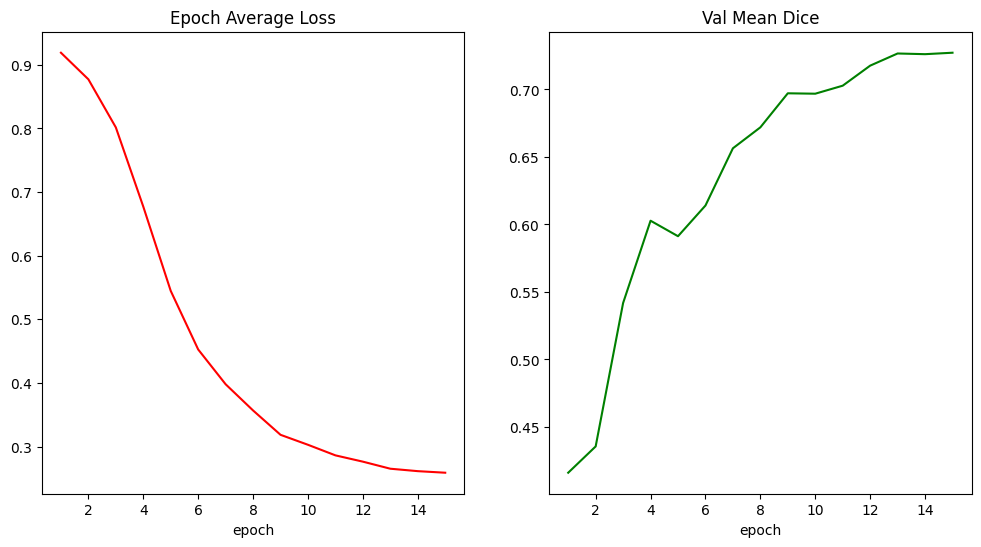

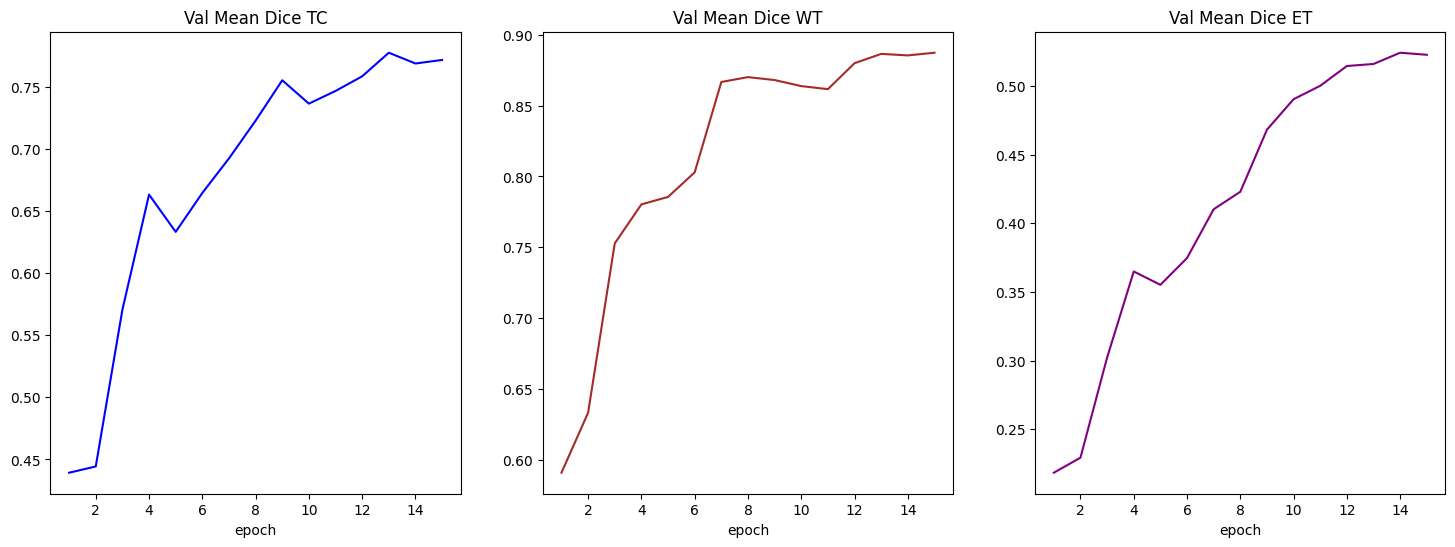

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

<ipython-input-15-c5ff286fafe0>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
<ipython-

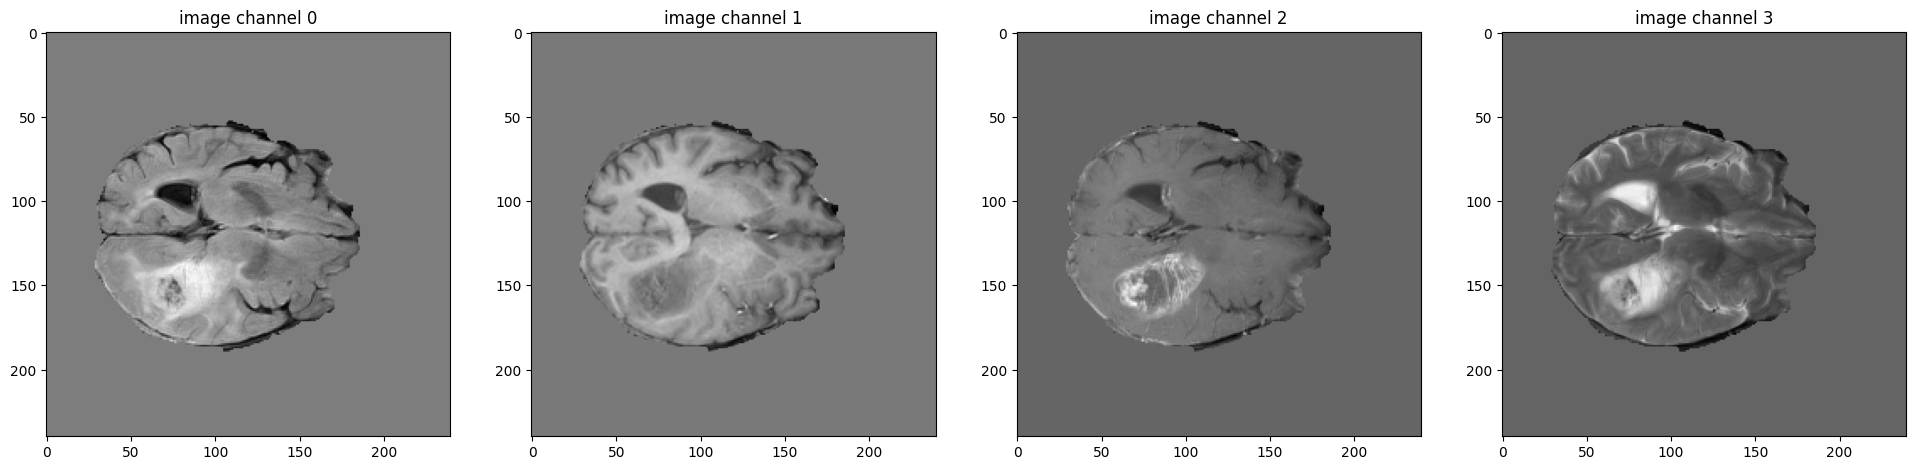

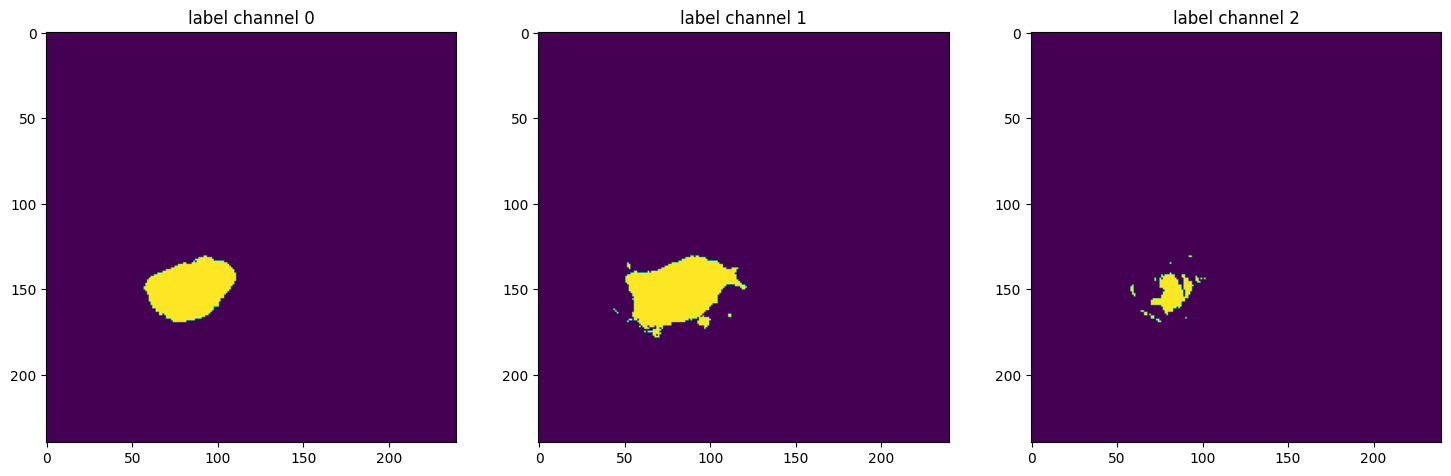

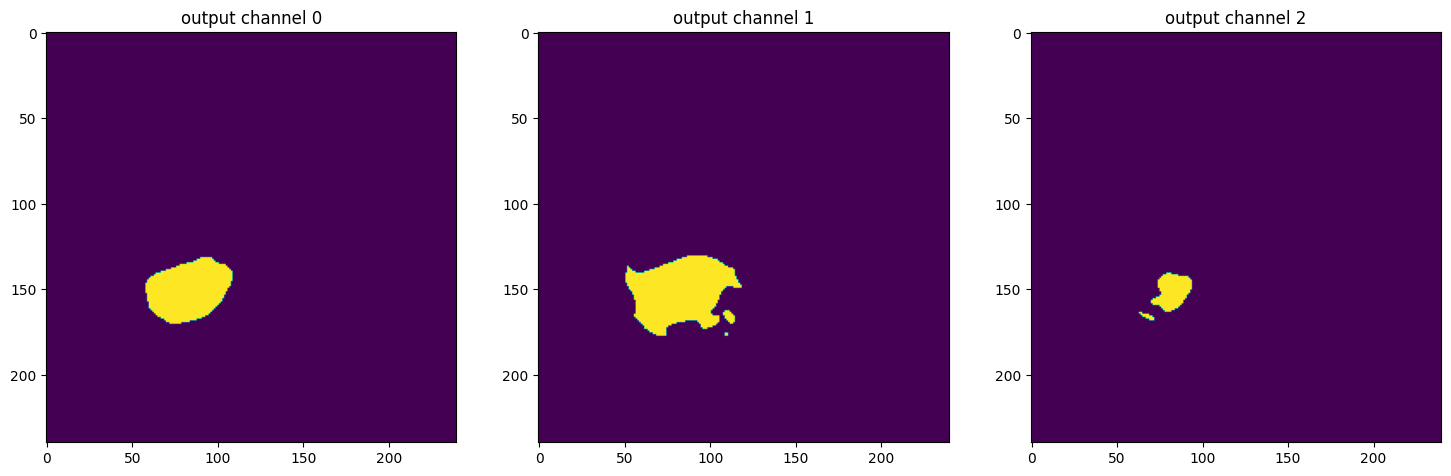

In [15]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()


In [16]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

val_org_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    transform=val_org_transforms,
    section="validation",
    download=False,
    num_workers=4,
    cache_num=0,
)
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=4)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)


In [17]:
import torch
import os

# Specify the path where you want to save the model in Kaggle's output directory
save_path = "/kaggle/working/final_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), save_path)

print(f"Model saved to {save_path}")


Model saved to /kaggle/working/final_model.pth
